# <center>Report of Problem3 (practical part of Assignment 1)</center>
# <center>IFT6135-H19</center>

This file only contains the report of problem3 of practical part of assignment1. Please refer to other files for the report of problem1&2.

**Codes link**: https://github.com/qqiang00/IFT6135/blob/master/hw1/prob3_hw1_final.ipynb

**Team member**: 
- Qiang Ye (20139927)
- Ying Xiao (20111402)
- Boumaza Amel (20126028)
- Yunhe Li (20137167)

**Notes**:
Before running the codes, make sure you have the following files in your current working directory
- `utils.py`: contains two tool functions (`debug` and `print_progress`)
    this file can be downloaded here:  https://github.com/qqiang00/IFT6135/tree/master/hw1
- dataset: can be downloaded here: https://www.kaggle.com/c/ift6135h19/data



## Brief Introduction of the Report
This report is for an in-class Kaggle competition: building a CNN model, training and testing the model on Cats-Dogs datasets. Our codes are based on `PyTorch` with the modules: `torch` and `torchvision`, and are executed on Google Colab platform. 

We built 2 different CNN architectures, training them on different hyper-parameter (learning_rate, batch_size) settings. At the very beginning, since the training and validation datasets are given by image files organized in different folders, we first tended to use `ImageFolder` to create our datasets, which made the consequent training process extremely slow due to constant reading data from an image file. Then, we convert  all the images(with labels) into single tensor for training, which brought the training process much faster. In order to reuse the tensors converted, we shuffled the samples in the tensor and save the tensor as a file :`train_set_shuffled.pt`, and we did similar procedure(without shuffle) on test dataset and generate a file: `test_set.pt` for testing.

The whole training dataset is split to 16998 training and 3000 validation samples after being randomly shffuled. Without data augmentation, both model achieved more than 80% accuracy on validation dataset, but the performance on test dataset was as bad as a random classifier. After checking the well matched predicted label and corresponding image manually, we found the problem came from a wrong mapping from our converted tensor index to the image filename. After fixing this problem, also with the help of data augmentation( horizontal flipping and small degree of rotate), our model performance on test dataset achieved nearly 90%, thus we stopped here.

Besides, we explored several other hyper-parameter settings, reported the differences of their performances, visualized some images that make our trained model confused or and those images that our model predict a label with very high confidence but wrong, and performaned basic analysis on this.

## 0. Support for Computation on Google Colab
Ignore this part if not on Googla Colab.

In [4]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)

Mounted at /content/dirve/


In [0]:
# check if we are in the right working directory
# change to your own directory

os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw1")
#!ls -al

## 1. Modules and Utils Functions

### 1). import necessary modules and try to use CUDA

In [6]:
from __future__ import print_function, division
from utils import debug, print_progress
import torch, torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
import sys
import PIL
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler

# use GPU as priority if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
else:
    device = torch.device('cpu')
    use_cuda = False
    
torch.set_default_tensor_type(torch.FloatTensor)
print(device)

DEBUG = True

cuda


### 2). Create Folders for Models and Submissions

To better organize the models and submissions created by different model architecture, we use the following codes to create two folders in current working directory.

In [0]:
# build two directories for saving model and submission files.
folders = ['./models', './submissions']
for i in range(len(folders)):
    if not os.path.exists(folders[i]):
        try:
            debug("creating folder: '{}'. ".format(folders[i]), end = "")
            os.mkdir(folders[i])
            debug("success.")
        except():
            debug("failure.") 

## 2. Preparation of  Datasets


### 1). Load Datasets from Folders and Convert to Torch Tensor

First, we download the datasets from Kaggle platform to local(or Google) drive. All data are image files in certain sub-folders, each indicating the label of the images in it.

Since, on Google Colab, training process is very slow if data are read from folders using `torchvision.datasets.ImageFolder`, we built a method `dataset_to_tensor` to convert datasets to `torch.tensor`s and then save them to  files to speed up training process. The tensor returned by this method is 2 dimensional like (N_sample, n_total_features + 1)

The next code cell only need to be executed one time to create two tensor files: `train_set_shuffled.pt` and `test_set.pt`.

**Check** if there exist these 2 files in your current working directory. If yes, you don't need to run this cell.

Later codes will read these 2 files to generate training, validation and test datasets.

In [0]:
def dataset_to_tensor(dataset):   
    """convert a torch.utils.data.datasets to a torch tensor
    Params
        dataset: a torch.utils.data.datasets
    Returns
        result: a torch tensor shape (n_samples, n_features + 1)
    """
    shape =len(dataset), dataset[0][0].reshape(1, -1).shape[1] + 1
    result = torch.zeros(shape)
    print(shape)
    for i in range(shape[0]):
        sample_X = dataset[i][0].reshape(1, -1)
        sample_y = torch.tensor([[dataset[i][1]]], dtype = torch.float32)
        sample = torch.cat((sample_X, sample_y), 1)
        result[i,:] = sample
        if i % 100 == 0:
            print_progress(i/shape[0])
    return result

# um comment the following code lines if "train_set.pt" and "test_set.pt" do not 
# exist.

#transform = transforms.Compose([
#    transforms.ToTensor(),
#])

#train_valid_set = datasets.ImageFolder(root = 'trainset', transform = transform)
#train_valid_tensor = dataset_to_tensor(train_valid_set)
# shuffle tensors
#train_valid_numpy = train_valid_tensor.numpy()
#np.random.shuffle(train_valid_numpy)
#train_valid_tensor = torch.tensor(train_valid_numpy)

#torch.save(train_valid_tensor, "train_set2.pt")

#test_dataset = datasets.ImageFolder(root = 'testset', transform = transform)
#test_tensor = dataset_to_tensor(test_dataset)
#torch.save(test_tensor, "test_set2.pt")


Once tensor files are created, run the following code to load a tensor from a file.

In [9]:
train_valid_tensor = torch.load("train_set.pt")
print(train_valid_tensor.shape)
print(train_valid_tensor[0:10,-1])
# 12289 = 3 * 64 * 64 + 1

torch.Size([19998, 12289])
tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 0.])


### 2). Visualization of a data sample.

All images are of 64*64 pixels with 3 (RGB) channels. Let's see what a image may look like.

In [0]:
int2labels = {0:"Cat", 1:"Dog"}
    
def show_img(data_sample, label = None, cmap = "gray"):
    """visualization of a image represented by a tensor
    Params
        data_sample: a tensor with shape (3, 64, 64)
        label: true label of that image: Cat or Dog
    Returns None
    """
    
    img_data = TF.to_pil_image(data_sample)
    n_channels = data_sample.size()[0]
    height, width = data_sample.size()[1:3]
    print(height, width)
    if n_channels == 3:
        plt.imshow(img_data)
    else:
        plt.imshow(img_data, cmap = cmap)
    if label is not None:
        print("label:",int2labels[label])
    plt.show()

<class 'torch.Tensor'>
64 64
label: Dog


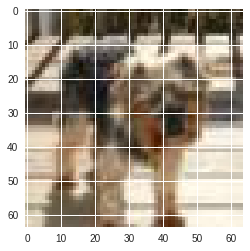

In [11]:
i = 10 # change the value of i to display different image.
# as in train_valid_tensor, one data sample is a one-dimensional data with last
# column stores the label, we need split it to tow parts: image data and image 
# label, and reshape the image data to (3,64,64).
data_sample = train_valid_tensor[i,:-1].reshape(3, 64, 64)
print(type(data_sample))
label = train_valid_tensor[i, -1].item()
show_img(data_sample, label)

### 3). Split to Training and Validation Datasets



As we have 19998 samples, it is a proper choice to set the number of validation samples be 3000.

Split the whole dataset to training and validatoin dataset with the  number of samples 16998 and 3000 respectively. 

Reshape the tensors for a CNN network.

In [12]:
#split dataset to training dataset and validation dataset
n_total = train_valid_tensor.shape[0]
n_valid = 3000
# split dataset to training dataset and validation dataset
train_tensor = train_valid_tensor[:n_total - n_valid,:]
train_X = torch.reshape(train_tensor[:, :-1], (-1, 3, 64, 64))
train_y = torch.reshape(train_tensor[:, -1], (-1, ))

valid_tensor = train_valid_tensor[n_total - n_valid: n_total, :]

valid_X = torch.reshape(valid_tensor[:, :-1], (-1, 3, 64, 64))
valid_y = torch.reshape(valid_tensor[:, -1], (-1, ))
valid_y = valid_y.long()

print(train_tensor.shape, train_X.shape, train_y.shape)
print(valid_tensor.shape, valid_X.shape, valid_y.shape)

torch.Size([16998, 12289]) torch.Size([16998, 3, 64, 64]) torch.Size([16998])
torch.Size([3000, 12289]) torch.Size([3000, 3, 64, 64]) torch.Size([3000])


### 4). Data Augmentation for training dataset(Tensor)

Training dataset is augmented by horizontal flipping and a slight degree of rotation.

In [0]:
def data_aug(tensor_X, operator, *args, **kwargs):
    """use specified operation to produce more image tensors
    Params
        tensor_X: torch tensor with shape [n_sample, 3, 64, 64]
        operator: a torch.functional, such as torch.functional.rotate
        *args, **kwargs: parameters for operator
    Returns
        a torch tensor with same shape of tensor_X
    """
    result_X = tensor_X.clone()
    n = result_X.shape[0]
    for i in range(n):
        img = TF.to_pil_image(result_X[i])
        img = operator(img, *args, **kwargs)
        result_X[i] = TF.to_tensor(img)
    return result_X


def merge_augmented(train_Xs, train_y):
    """Merge augmented data
    Params
        train_Xs is a list of tensor
        train_y is a tensor of labels for first element of the train_Xs list
    Returns
        (Xs, ys) a tuple with merged X and y
    """
    n = len(train_Xs)
    ys = torch.cat(tuple([train_y for i in range(n)]), 0)
    Xs = torch.cat(train_Xs, 0)
    ys = ys.long()
    return Xs, ys

After data augmentation, training dataset now has 67992 samples.

In [14]:
# This code cell may cost some time, be patient.
train_Xs = [train_X]
train_Xs.append(data_aug(train_X, TF.hflip))

train_Xs.append(data_aug(train_X, TF.rotate, -5))
train_Xs.append(data_aug(train_X, TF.rotate, 5))

# too large for my laptop
#train_Xs.append(data_aug(train_X, TF.rotate, -10))
#train_Xs.append(data_aug(train_X, TF.rotate, 10))
#train_Xs.append(data_aug(train_X, TF.rotate, -15))
#train_Xs.append(data_aug(train_X, TF.rotate, 15))

train_X_agm, train_y_agm = merge_augmented(train_Xs, train_y)
print(train_X_agm.shape, train_y_agm.shape)

torch.Size([67992, 3, 64, 64]) torch.Size([67992])


### 5). Final training and validation datasets
Here comes to our final training and validation dataset for training. We will use `train_dataset`, `valid_dataset` to train and validating all our models.

In [0]:
train_dataset = torch.utils.data.TensorDataset(train_X_agm, train_y_agm)
valid_dataset = torch.utils.data.TensorDataset(valid_X, valid_y)

## 4. Different CNN architectures

In this section, we built 3 CNNs with different architecture. We first implemented a base class `MyModule` in which a method `count_parameters` is implemented to count the total number of parameters of a network. All our CNNs are inherited from this base class.

If not specified,  a convolutional operation use kernel size: `3`, stride size `1`, dilation: `1`, and padding: `0`; a max_pool operation use kernel size: `2` and stride size: `2`.  We use only `ReLU` activation function.

To describe a CNN architecture, we use the following notations:
- `Conv(n_input_channels, n_output_channels, kernel_size = 3, stride_size = 1, padding_size = 0)`: for a convolutional operation.
- `MaxPool`: for a default max pooling and subsampling operation.
- `Linear(n_input, n_output)`: for a Linear operation.
- `ReLU`: for a ReLU activation operation.
- `Res(n_input, n_output)`: a residual block of series operations: `Conv(n_input, n_output, padding = 1) -> ReLU (a)-> Conv(n_output, n_output, padding = 1) -> ReLU -> Conv(n_output, n_output, padding = 1) ->(b) ReLU`, where there is a shortcut from  `a` to `b`.

Here are the architectures of 3 different CNNs:

   1. **ConvNet1**: `Conv(3, 16) -> ReLU -> Conv(16, 32) -> ReLU ->  MaxPool -> Conv(32, 64) -> ReLU ->  Conv(64, 128) -> ReLU ->  Conv(128, 128) -> ReLU ->  MaxPool -> Conv(128, 128) -> ReLU ->  Conv(128, 128, 5) -> ReLU ->  Conv(128, 128, 5) -> ReLU ->  Linear(128, 64) ->  ReLU -> Linear(64, 2)`
   
   Total Parameters: 1220450
   
   
   2. **ConvNet3**: `Conv(3, 8) -> ReLU -> Conv(8, 16) -> ReLU ->  MaxPool -> Conv(16, 32) -> ReLU ->  Conv(32, 64) -> ReLU ->  MaxPool -> Conv(64, 128) -> ReLU ->  Conv(128, 256) -> ReLU ->   Linear(256, 2)` 
   
   Total Parameters: 394066
   
   
   3. **ConvNet4**: `Res(3, 16) -> MaxPool -> Res(16, 32) -> MaxPool -> Res(32, 64) -> MaxPool -> Res(64, 128) -> MaxPool -> Conv(128, 128, padding = 0) -> MaxPool -> Linear(128, 2)`
   
   Total Parameters: 637442
   
No batch normalization or dropout is used in these 3 CNNs.

In [0]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.name = type(self).__name__

    def net_name(self):
        return self.name
    
    def count_parameters(self):
        """count number of parameters of current model
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class ConvNet1(MyModule):
    """CNN with best result"""
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, 3, 1, 0) 
        self.conv12 = nn.Conv2d(16,32, 3, 1, 0) 
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv21 = nn.Conv2d(32, 64, 3, 1, 0) 
        self.conv22 = nn.Conv2d(64, 128, 3, 1, 0) 
        self.conv23 = nn.Conv2d(128, 128, 3, 1, 0) 
        
        self.conv31 = nn.Conv2d(128, 128, 3, 1, 0) 
        self.conv32 = nn.Conv2d(128, 128, 5, 1, 0) 
        self.conv33 = nn.Conv2d(128, 128, 5, 1, 0) 
        
        self.fc1 = nn.Linear(128, 64)              
        self.fc2 = nn.Linear(64, 2)                
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x):                             # 3    64   64
        x = self.relu(self.conv11(x))                 #16    62   62
        x = self.relu(self.conv12(x))                 #16    60   60 
        x = self.maxpool(x)                           #16    30   30
        
        x = self.relu(self.conv21(x))                 #32    28   28  
        x = self.relu(self.conv22(x))                 #64    26   26 
        x = self.relu(self.conv23(x))                 #64    24   24 
        x = self.maxpool(x)                           #64    12   12

        x = self.relu(self.conv31(x))                 #128   10   10  
        x = self.relu(self.conv32(x))                 #128    6   6  
        x = self.relu(self.conv33(x))                 #128    2   2  
        x = self.maxpool(x)                           #128    1   1 
        
        x = x.view(x.size(0), -1)                     # batch, 128
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x  
    
    
class ConvNet2(MyModule):
    """CNN with best result"""
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 16, 3, 1, 0) 
        self.conv12 = nn.Conv2d(16,32, 3, 1, 0) 
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv21 = nn.Conv2d(32, 64, 3, 1, 0)
        self.conv22 = nn.Conv2d(64, 128, 3, 1, 0) 
        self.conv23 = nn.Conv2d(128, 128, 3, 1, 0) 
        
        self.conv31 = nn.Conv2d(128, 128, 3, 1, 0) 
        self.conv32 = nn.Conv2d(128, 128, 5, 1, 0) 
        self.conv33 = nn.Conv2d(128, 128, 5, 1, 0) 
        
        self.fc1 = nn.Linear(128, 64)              
        self.fc2 = nn.Linear(64, 2)                
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        
        self.conv11_bn = nn.BatchNorm2d(16)
        self.conv12_bn = nn.BatchNorm2d(32)
        self.conv21_bn = nn.BatchNorm2d(64)
        self.conv22_bn = nn.BatchNorm2d(128)
        self.conv23_bn = nn.BatchNorm2d(128)
        self.conv31_bn = nn.BatchNorm2d(128)
        self.conv32_bn = nn.BatchNorm2d(128)
        self.conv33_bn = nn.BatchNorm2d(128)
        self.fc_drop = nn.Dropout(p = 0.5)
        
        
    def forward(self, x):                             # 3    64   64
        x = self.relu(self.conv11_bn(self.conv11(x))) #16    62   62
        x = self.relu(self.conv12_bn(self.conv12(x))) #16    60   60 
        x = self.maxpool(x)                           #16    30   30
        
        x = self.relu(self.conv21_bn(self.conv21(x))) #32    28   28  
        x = self.relu(self.conv22_bn(self.conv22(x))) #64    26   26 
        x = self.relu(self.conv23_bn(self.conv23(x))) #64    24   24 
        x = self.maxpool(x)                           #64    12   12

        x = self.relu(self.conv31_bn(self.conv31(x))) #128   10   10  
        x = self.relu(self.conv32_bn(self.conv32(x))) #128    6   6  
        x = self.relu(self.conv33_bn(self.conv33(x))) #128    2   2  
        x = self.maxpool(x)                           #128    1   1 
        
        x = x.view(x.size(0), -1)                     # batch, 128
        x = self.fc_drop(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.softmax(x)
        return x
    
    
class ConvNet3(MyModule):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 0) 
        self.conv2 = nn.Conv2d(8,16, 3, 1, 0) 
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 0) 
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 0) 
        self.conv5 = nn.Conv2d(64, 128, 3, 1, 0) 
        self.conv6 = nn.Conv2d(128, 256, 3, 1, 0) 
        
        self.fc1 = nn.Linear(256, 2)              

        
    def forward(self, x):             # 64                 
        x = self.relu(self.conv1(x))  # 62          
        x = self.relu(self.conv2(x))  # 60                
        x = self.maxpool(x)           # 30                
        
        x = self.relu(self.conv3(x))  # 28              
        x = self.maxpool(x)           # 14
        
        x = self.relu(self.conv4(x))  # 12
        x = self.maxpool(x)           # 6
               
        x = self.relu(self.conv5(x))  # 4
        x = self.relu(self.conv6(x))  # 2
        x = self.maxpool(x)           # 1
        
        x = x.view(x.size(0), -1)                     
        x = self.fc1(x)
        return x

    
class ConvNet4(MyModule):
    def __init__(self):
        super(ConvNet4, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        
        self.conv11 = nn.Conv2d(3, 16, 3, 1, 1) 
        self.conv12 = nn.Conv2d(16, 16, 3, 1, 1)
        self.conv13 = nn.Conv2d(16, 16, 3, 1, 1)
        
        self.conv21 = nn.Conv2d(16, 32, 3, 1, 1) 
        self.conv22 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv23 = nn.Conv2d(32, 32, 3, 1, 1)
            
        self.conv31 = nn.Conv2d(32, 64, 3, 1, 1) 
        self.conv32 = nn.Conv2d(64, 64, 3, 1, 1) 
        self.conv33 = nn.Conv2d(64, 64, 3, 1, 1) 
        
        self.conv41 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv42 = nn.Conv2d(128, 128, 3, 1, 1) 
        self.conv43 = nn.Conv2d(128, 128, 3, 1, 1) 
        
        self.conv51 = nn.Conv2d(128, 128, 3, 1, 0) 
        self.fc1 = nn.Linear(128, 2)              

        
    def forward(self, x):             # 64                 

        x = self.relu(self.conv11(x))  # 64          
        residual = x
        x = self.relu(self.conv12(x))  # 64                
        x = self.conv13(x)  # 64    
        x += residual
        x = self.relu(x)
        x = self.maxpool(x)            # 32
        
        x = self.relu(self.conv21(x))  
        residual = x
        x = self.relu(self.conv22(x))  # 32
        x = self.conv23(x)  # 32
        x += residual
        x = self.relu(x)
        x = self.maxpool(x)           # 16
        
        x = self.relu(self.conv31(x))  # 16
        residual = x
        x = self.relu(self.conv32(x))  # 16
        x = self.conv33(x)  # 16
        x += residual
        x = self.relu(x)
        x = self.maxpool(x)           # 8
                                      
        x = self.relu(self.conv41(x)) 
        residual = x
        x = self.relu(self.conv42(x))  # 8
        x = self.conv43(x)  # 8
        x += residual
        x = self.relu(x)
        x = self.maxpool(x)            # 4

        x = self.relu(self.conv51(x))  # 2
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)                     
        x = self.fc1(x)
        return x    
    

Number of total trainable  parameters for each architecture:

In [17]:
debug("Number of total trainable parameters for each architecture:")
for model in [ConvNet1(), ConvNet3(), ConvNet4()]:
    print("{}:{}; ".format(model.name, model.count_parameters()), end = " ")

Number of total trainable parameters for each architecture:
ConvNet1:1220450;  ConvNet3:394066;  ConvNet4:637442;  

## 5. Training a CNN model

A function `train_model` is implemented to training a model. After each epoch of training, we check the model on validation dataset, recording training/validation losses and training/validating accuracies for each epoch, and return these data when whole training is completed. We use early stopping technique to avoid overfitting the training dataset. Only `SGD`(without momentum) is used to perform the gradient descent. No regulirazation is used. 

`train_model` will automatically save model parameters and finally save our best model parameters. 

**Caution**:  if you re-shuffle the whole training datasets and then split them with a different number of validation sample, do not load model parameters from a save file, which may may cause the model has meet some validation samples.

See the code comment for more details of this function. 



In [0]:
def train_model(model, 
                learning_rate,
                train_dataset,
                valid_dataset,
                auto_save_path,
                best_model_path,
                scheduler = None, 
                max_epochs = 20, 
                early_stopping = False, 
                epoch_patience = 5,
                auto_load_best_after_train = True,
                auto_save_interval = 1,
                batch_size = 256,
                show_live_progress = False,
                trainer = "Ying"
                ):
    """train a model
    Params
        model: to be trained, nn.Module
        train_valid_set: merge of training and validating set
        n_valid_sample: number of validating samples
        scheduler: learning rate scheduler
        auto_save_path: path where latest model will be auto saved
        best_model_path: path where best model will be saved
        max_epochs: max epochs, int
        early_stopping: decide if training will stop earlier according to 
            accuracy on validating dataset, Bool
        epoch_patience: if accuracy on validate set decreases, we don't stop
            at the epoch, we need to go extra epoch_patience number of epoch
            to confirm this decreasing trends, int
        auto_load_best_after_train: whether we load our best model paramters
            after the training process is complete, Bool
        auto_save_interval: the interval we auto save the parameters of the 
            model, int
        batch_size: batch_size, int      
    Returns
        # model: trained, nn.Module
        losses: losses during training and validating, 
            dict {"train", [double], 'val': [double]}
        accuracies: accuracies during training and validating, 
            dict {"train", [double], 'val': [double]}
        cache: a cache dict {'best_model_wts':best_model_wts,
                             'best_acc_val':best_acc_val,
                             'optimizer':optimizer,
                             'model':model
                            }
    """
    
    model.to(device)
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(valid_dataset)
    }
    dataloaders = {
        'train':torch.utils.data.DataLoader(
            train_dataset, batch_size = batch_size, shuffle = True),
        'val':torch.utils.data.DataLoader(
            valid_dataset, batch_size = batch_size)
    }
    print("trainer:{}, model:{}, learning_rate:{}, batch_size:{}".format(
        trainer, model.net_name(), learning_rate, batch_size))
    print("model parameters:{}".format(model.count_parameters()))
    print("training/validation:", len(train_dataset),"/", len(valid_dataset))
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    #scheduler = lr_scheduler.MultiStepLR(
    #        optimizer,  
    #        milestones = [50, 70, 80, max_epochs - 10], 
    #        gamma = 0.1)
    best_model_wts = copy.deepcopy(model.state_dict())  # for best parameters
    best_acc = {'train':0.0, 'val':0.0}                 # best accuracy
    losses = {'train': [], 'val':[]}
    accuracies = {'train': [], 'val':[]}
    patience_used = 0                                   # patience used
    early_stopped = 0
    debug("'s': auto saved, '*': best accuracy so far.")
    start = time.time()    
    for epoch in range(max_epochs):
        since = time.time()
        # s_before and s_after are for print trainig progress
        s_before = '[Epoch{:>3d}/{} '.format(epoch, max_epochs - 1)
        s_after = ']'
        if show_live_progress:
            print_progress(0, 0, s_before, s_after)
        else:
            print(s_before + s_after, end = "")

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            since_phase = time.time()
            if phase == 'train': # train
                if scheduler is not None:
                    scheduler.step()
                model = model.train()  # Set model to training mode
            else:
                model = model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_size = 0
            if show_live_progress:
                print_progress(0, 0, s_before, s_after)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                test_start = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # accumulate loss and correctly predicted sample number
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.data == labels.data).item()
                running_size += preds.size(0)
                
                if show_live_progress:
                    time_elapsed = time.time() - since_phase
                    print_progress(running_size/dataset_sizes[phase], 
                                   time_elapsed, 
                                   s_before, 
                                   s_after)
                    already_show_estimated_time = True
                test_end = time.time()
                #print(test_end - test_start)
                # end batches loop
                
            # compute average loss and accuracy after a traing or validate phase
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # keep current loss and accuracy data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            time_elapsed = time.time() - since_phase
            s_after += ' {} loss: {:.4f} acc: {:<7.2%} '.format(
                phase, epoch_loss, epoch_acc)
            

            # check current parameters achieved best performance so far
            # if YES, keep a reference to the best parameters.
            if epoch_acc > best_acc[phase]:
                best_acc[phase] = epoch_acc
                if phase == 'val':
                    s_after += " *"
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_used = 0
            else:
                if phase == 'val': # avoid repeating check for both training
                                   # and validating phase
                    patience_used += 1 # 
                    if early_stopping and patience_used >= epoch_patience:
                        # patience is used up
                        early_stopped = epoch - epoch_patience
                        
            if show_live_progress:
                print_progress(running_size/dataset_sizes[phase], 
                               time_elapsed, s_before, s_after)
            else:
                print(' {} loss: {:.4f} acc: {:<7.2%} '.format(
                    phase, epoch_loss, epoch_acc), end = " ")                        
            #end phase loop
    
        time_elapsed = time.time() - since
        if show_live_progress:
            print_progress(1, time_elapsed, s_before, s_after)
        else:
            print(' {:.0f}m{:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60), end = "")
        # display some information
        #if epoch_acc == best_acc['val']:
        #    print("*", end="")
        #else:
        #    print("", end="")
        if early_stopped or epoch == (max_epochs - 1) or \
           (epoch + 1) % auto_save_interval == 0:
            
            model_name = "{}_{}_{}_{}".format(
                trainer, model.net_name(), str(learning_rate), str(batch_size))
            model_path_auto_save = auto_save_path + "_" + model_name + ".model"
            model_path_best = best_model_path + "_" + model_name + ".model"
            
            torch.save(model.state_dict(), model_path_auto_save)
            torch.save(best_model_wts, model_path_best)
            print(" s") # saved
        else:
            print("") # new line

        if early_stopped > 0:
            print("Early stop at epoch: {}".format(early_stopped))
            break
        #end epoch loop 
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    for phase in ["train", "val"]:#phases:        
        print('Best val Acc on {}: {:.2%}'.format(phase, best_acc[phase]))
    # load best model weights
    
    if auto_load_best_after_train:
        model.load_state_dict(best_model_wts)
        
    train_info = {
        "best_acc_train": best_acc["train"],
        "best_acc_val": best_acc["val"],
        "time_elapsed": time_elapsed,
        "early_stopped": early_stopped,
        "epoch_passed": epoch + 1,
        "model_name": model_name
    }
    return losses, accuracies, train_info

In [0]:
def learning_curve(losses, accuracies, model_name):
    """plot learning curve
    Params
        losses: a dictionary {"train": [float], "val": [float]}
        accuracies: a dictionary {"train": [float], "val": [float]}
    """
    support = np.arange(len(losses['train']))
    plt.figure(figsize = (14, 6))
    plt.grid(True) # add a grid

    plt.subplot(1,2,1)
    plt.plot(support, losses['train'], 'g-', label = 'train')
    plt.plot(support, losses['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title("Loss curves: {}".format(model_name))
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(support, accuracies['train'], 'g-', label = 'train' )
    plt.plot(support, accuracies['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title("Accuracy curves: {}".format(model_name))
    plt.legend(loc='lower right')
    
    plt.savefig("models/" + model_name + ".png")
    plt.show()

In [0]:
models = [ConvNet1] #[ConvNet1, ConvNet3, ConvNet4] 
learning_rates = [0.01] # [1, 0.1, 0.01, 0.001]
batch_sizes = [32] # [1, 32, 256, 1024]

# if you once interrupted this code cell and want to continue try different
# hyper-parameter settings, you may insert the setting already trained in
# this list.
settings_trained = []
n_models = len(models)
n_lrs =  len(learning_rates)
n_batch_sizes = len(batch_sizes)

# total times of searching is not bigger than number of all possibilities.
n_search = n_lrs * n_batch_sizes
trainer = "Qiang"

for i in range(n_search):
    print("-"* 30)
    model_index, lr_index, batch_size_index = 0, 0, 0
    while True:
        # generate a new hyper-parameter setting
        model_index = np.random.randint(n_models)
        lr_index = np.random.randint(n_lrs)
        batch_size_index = np.random.randint(n_batch_sizes)
        
        setting = (model_index, lr_index, batch_size_index)
        if not setting in settings_trained:
            # setting not trained
            break
    
    model = models[model_index]()
    learning_rate = learning_rates[lr_index]
    batch_size = batch_sizes[batch_size_index]
        
    losses, accuracies, train_info = train_model(
            model = model,
            learning_rate = learning_rate,
            batch_size = batch_size,
            train_dataset = train_dataset,
            valid_dataset = valid_dataset,
            auto_save_path = './models/auto_save',
            best_model_path = './models/best',
            max_epochs = 100, 
            early_stopping = True, 
            epoch_patience = 30,
            auto_load_best_after_train = True, # 
            auto_save_interval = 10,# every 10 epochs, save model parameters
            show_live_progress = True,
            trainer = trainer
        )
    learning_curve(losses, accuracies, train_info["model_name"])
    # add this setting to trained list.
    settings_trained.append(setting)
    # continue new hyper-parameter setting until all combinations are trained.

This table shows the architectures and combination of hyper-parameters we trained. Some records show relatively low accuracy on training and validation datasets because we set the max training epochs to 100 and the learning rates is too small (1e-4). As early stopping was used, learning rate with 0.1 also have a good performance on validation dataset, and models with this learning_rate usually stopped much earlier than other learning rates. We found that although `ConvNet4` has nearly half number of parameters of `ConvNet1`, its performance on validation dataset is almost the same as `ConvNet1`.  It is very difficult to reason about the performance difference.

Our performance on Kaggle is about 89.9%, predicted by a `ConvNet1` model. This result is a little higher than best performance on validation datasets.

To improve the performance on validation dataset, We believe that  more data augmentation is a practical choice. As long as the model capacity is large enough, more training data will have a very high probability to achieve better performance. 

Run the following code to load a pre-trained model.

In [18]:
model = ConvNet4()
print("{} is the total number of parameters of current model".format(
    model.count_parameters()))

# change the model_file name
model_file = "models/best_Qiang_ConvNet4_0.1_32.model"
model.load_state_dict(torch.load(model_file))

637442 is the total number of parameters of current model


## 6. Performance on Validation Set

The following two methods `predcit`, `analysis_predict` help us to make a prediction based on a trained model and primarily analyze the prediction. 

We analyze the prediction by generating the confusion matrix, displaying those images which our model give a very close prediction on both Dog and Cat, and displaying those images which our model predicted wrong with a very high probability.

In [0]:
def predict(model, test_set, batch_size = 128):
    """predict using a model on a dataset(test_X)
    params
        model: nn.Module
        test_X: dataset, narray (n_size, n_feature)
    returns
        predict_labels: prediction, np.array, (n_size, )
        outputs: probability np.array, (n_size, 2)
    """
    since = time.time()
    model.to(device)
    model.eval()   # Set model to evaluate mode
    predict_labels, outputs = [], []
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
    # Iterate over data.
    i = 0
    n_total = len(test_set)
    for batch_inputs in test_loader:
        batch_inputs = batch_inputs[0].to(device)
        with torch.set_grad_enabled(False):
            batch_outputs = model(batch_inputs)
            batch_predict = torch.argmax(batch_outputs, dim = 1)
            batch_predict = batch_predict.cpu().numpy().tolist()
            
            predict_labels.extend(batch_predict)
            
            outputs.append(batch_outputs)
            
            i += batch_inputs.size(0)
            print_progress(i / n_total)
    outputs = torch.cat(outputs, dim = 0)
    outputs = nn.functional.softmax(outputs, dim = 1)
    outputs = outputs.cpu().numpy()
    predict_labels = np.array(predict_labels)
    return predict_labels, outputs


def analysis_predict(probs, labels, close_p = 0.05, far_p = 0.95):
    n_sample = labels.shape[0]
    
    index = np.arange(n_sample)
    pred_labels = np.argmax(probs, axis = 1)
    
    data = np.concatenate((index.reshape(-1, 1),       # index
                           labels.reshape(-1, 1),      # True labels
                           pred_labels.reshape(-1, 1), # predict labels
                           probs[:,0].reshape(-1, 1)), # probability of cat
                          axis = 1)
    cat_cat, cat_dog, dog_dog, dog_cat = 0, 0, 0, 0 # label_predict
    
    close_mis_indices = [] # index that mis classified yet with close probability
    far_mis_indices = [] # indices that mis classified with high probability
    
    for i in range(n_sample):
        index, label, pred, prob = int(data[i,0]), data[i,1], data[i,2], data[i,3]
        if label + pred > 1.9:# dog_dog
            dog_dog += 1
        elif label + pred < 0.1:# cat_cat
            cat_cat += 1
        else:# mis classified
            if abs(prob - 0.5) <= close_p:
                close_mis_indices.append(index)
            elif prob <= 1 - far_p or prob >= far_p:
                far_mis_indices.append(index)
            if label > pred: # dog_cat:
                dog_cat += 1
            else: # cat_dog
                cat_dog += 1
    
    print("confusion matrix:")
    print("            Label_Cat       Label_Dog")
    print("Pred_Cat:   {:^9}       {:^9}    ".format(cat_cat, dog_cat,))
    print("Pred_Dog:   {:^9}       {:^9}    ".format(cat_dog, dog_dog))
    print("")

    print("{} sample(s)".format(len(close_mis_indices)), end = " ")
    print("mis-classified with probabilities within {:4.2%}-{:4.2%}".format(
        0.5 - close_p, 0.5 + close_p))
    
    print("{} sample(s)".format(len(far_mis_indices)), end = " ")
    print("mis-classified with probability <={:4.2%} or >={:4.2%}".format(
        1-far_p, far_p))
    
    indices = {0: close_mis_indices, 1: far_mis_indices}
    for k in range(2):
        plt.figure(figsize=(16, 40))
        for i in range(len(indices[k])):
            plt.subplot(12, 5, i+1)
            index = indices[k][i]
            img_data = TF.to_pil_image(valid_X[index,:])
            title = "{}-{}  {} ({:4.2%})\n".format( 
                index,
                int2labels[valid_y[index].item()],
                int2labels[valid_pred[index]], 
                valid_probs[index,valid_pred[index]])
            plt.imshow(img_data)
            plt.text(0, 0, title)
        plt.subplots_adjust(wspace = 0.01, hspace = 0.3)
        plt.show()
    
    return 
    #return (cat_cat, cat_dog, dog_dog, dog_cat, indices)

In [26]:
valid_pred, valid_probs = predict(model, valid_dataset)

progress:100.00%

confusion matrix:
            Label_Cat       Label_Dog
Pred_Cat:     1467             60        
Pred_Dog:      43             1430       

3 sample(s) mis-classified with probabilities within 49.50%-50.50%
16 sample(s) mis-classified with probability <=1.00% or >=99.00%


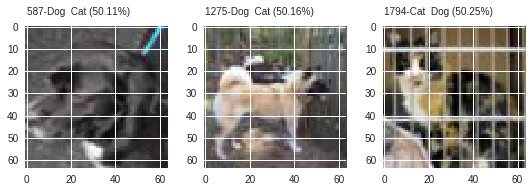

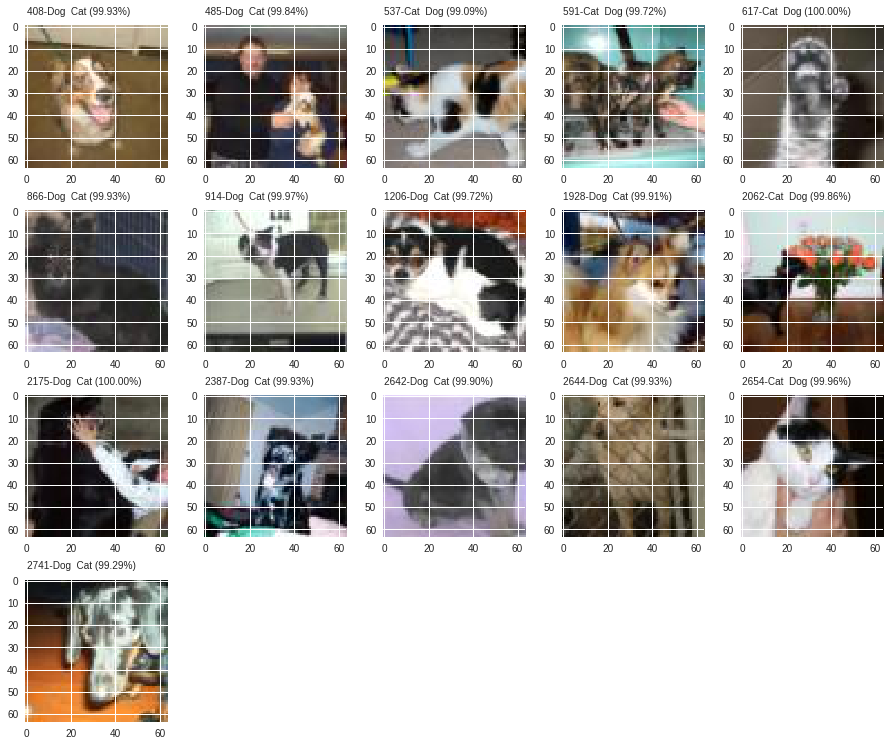

In [47]:
data = analysis_predict(valid_probs, valid_y, close_p = 0.005, far_p = 0.99)

#### Feature map

Load a pretrained model, select one data sample, pass through the model, we visualize the outputs of each convolutional layer with ReLU activated.

In [25]:
model = ConvNet4()
print("{} is the total number of parameters of current model".format(
    model.count_parameters()))

# change the model_file name
model_file = "models/best_Qiang_ConvNet4_0.1_32.model"
model.load_state_dict(torch.load(model_file))

global conv_features
conv_features = []
def get_conv_feature(self, input, output):
    global conv_features
    conv_features.append(output.data)
    return None

handlers = []
for module in model.named_children():
    if type(module[1]) == nn.Conv2d:
        #print(module)
        handlers.append(module[1].register_forward_hook(get_conv_feature))
        #print(module)
        
print(len(conv_features), len(handlers))

637442 is the total number of parameters of current model
0 13


64 64
label: Cat


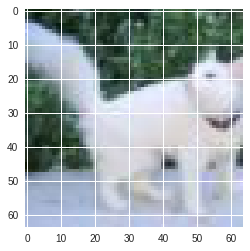

In [69]:
#prepare a sample
n_valid_sample = len(valid_dataset)
i = 1416#np.random.randint(n_valid_sample)
sample_tensor = valid_dataset[i][0]
sample_label = valid_dataset[i][1].item()
show_img(sample_tensor, sample_label)

In [27]:
input_tensor = torch.unsqueeze(sample_tensor, 0)
model.forward(input_tensor)
print(len(conv_features))

13


In [0]:
'''
def catenate(tensor, n_col = None):
    """convert a tensor [n_channels, height, width] to a [1, height1, width1]
    tensor for visualization
    Params
        tensor: original tensor, [n_channels, height, width]
        n_col: number of [1, heights, width], 
               which makes a new tensor [1, height, width*n_col]
    Returns
        new_tensor: [1, height1, width1] where width1 = min{n_col, n_channels}
    """
    tensor_shape = tensor.shape
    n_channels = tensor_shape[0]
    unit_shape = tensor_shape[1], tensor_shape[2]
    if n_col == None:
        n_col = int(np.ceil(np.sqrt(n_channels)))
    if n_col > n_channels:
        n_col = n_channels
    n_row = int(np.ceil(n_channels / n_col))
    n_left = n_channels
    i = 0
    tensor_rows = []
    while n_left > 0:
        temp = None
        if n_left >= n_col:
            temp = [tensor[k] for k in range(i, i + n_col)]
            i += n_col
        else:
            n_padding = n_col - n_left
            temp = [tensor[k] for k in range(i, i + n_left)]
            for _ in range(n_padding):
                temp.append(torch.zeros(unit_shape))
            
            i += n_left
            
        n_left = n_channels - i            
        tensor_row = torch.cat(temp, 1)
        tensor_rows.append(tensor_row)
    
    result = torch.cat(tensor_rows, 0)
    result = torch.unsqueeze(result, 0)
    return result
'''

In [0]:
def visualize(tensor, scale = 1):
    """visualize a 3 dimensional tensor channel by channel, with each channel
    represented by a 2D image
    """
    if len(tensor.shape) == 3:
        tensor = torch.unsqueeze(tensor, 1)
    n_channels, img_size = tensor.shape[0], tensor.shape[2:4]
    n_cols = int(np.ceil(np.sqrt(n_channels)))
    fig_size = n_cols * img_size[0] * scale / 64
    
    fig, axs = plt.subplots(n_cols, n_cols, 
                            figsize = (fig_size, fig_size), 
                            sharex='all', sharey='all',
                            subplot_kw = {'xticks': [], 'yticks': []})
    fig.subplots_adjust(wspace = 0.01, hspace = 0.01)
        
    for ax, i in zip(axs.flat, range(n_channels)):
        # here img_data could be a image with single channel, such as a feature
        # map, which will be displayed as a gray image; 
        # it could also be a data with more than 3 channels (such as kernel 
        # weights), which will be displayed as pseudo color images
        img_data = TF.to_pil_image(tensor[i])
        ax.imshow(img_data, interpolation = "bilinear")
   
    plt.show()
    
def visualize_feature_map(conv_features, layer = 0, scale = 1):
    print("Feature maps of layer: {} ".format(layer), end = " ")
    tensor = conv_features[layer][0]
    print(tensor.shape)
    visualize(tensor, scale)
    
def visualize_kernel_map(kernel_tensors, layer = 0, scale = 4):
    print("Kernel maps of layer:{}, ".format(layer), end = " ")
    tensor = kernel_tensors[layer]
    print(tensor.shape)
    visualize(tensor, scale)
    

Feature maps of layer: 0  torch.Size([16, 64, 64])


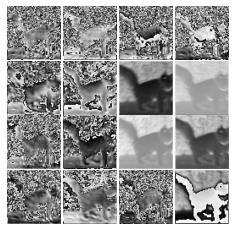

In [72]:
visualize_feature_map(conv_features, layer = 0)

Feature maps of layer: 10  torch.Size([128, 8, 8])


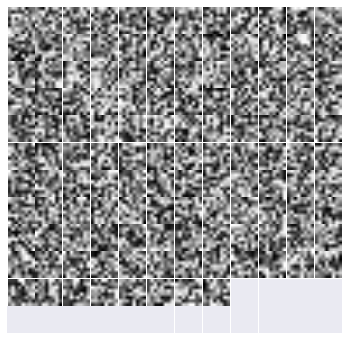

In [73]:
visualize_feature_map(conv_features, layer = 10, scale = 4)

#### Kernel map

In [0]:
param_tensors = []
for parameter in model.parameters():
    if len(parameter.size()) == 4: # kernel weights, not bias
        #print(parameter.shape)
        param_tensors.append(parameter.data)       

Kernel maps of layer:0,  torch.Size([16, 3, 3, 3])


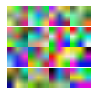

In [64]:
# visualize kernel map of layer0, whose size is 128 * 128 * 3 * 3
visualize_kernel_map(param_tensors, layer = 0, scale = 8)

Kernel maps of layer:6,  torch.Size([64, 32, 3, 3])


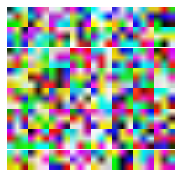

In [65]:
# visualize kernel map of layer6, whose size is 128 * 128 * 3 * 3
visualize_kernel_map(param_tensors, layer = 6, scale = 8)

Kernel maps of layer:10,  torch.Size([128, 128, 3, 3])


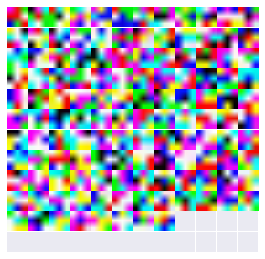

In [66]:
# visualize kernel map of layer10, whose size is 128 * 128 * 3 * 3
visualize_kernel_map(param_tensors, layer = 10, scale = 8)

According to the result of confusion matrix, our model has a close prediction error on both classes.

## 7. Test

In [0]:
test_tensor = torch.load("test_set.pt")
print(test_tensor.shape)
test_set_X = torch.reshape(test_tensor[:, :-1], (-1, 3, 64, 64))
test_set = torch.utils.data.TensorDataset(test_set_X)
print(type(test_set), len(test_set))

torch.Size([4999, 12289])
<class 'torch.utils.data.dataset.TensorDataset'> 4999


label: Cat


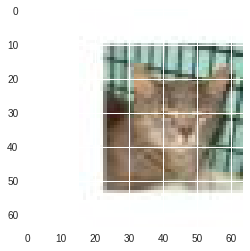

In [0]:
show_img(test_tensor[21,:-1].reshape(3,64,64), 0)

In [0]:
#model4 = ConvNet4()
#model4.load_state_dict(torch.load("models/best_ConvNet4.model"))
predict_labels, probs = predict(model, test_set)
probs[0:5:]

progress:100.00%

array([[9.9534768e-01, 4.6523511e-03],
       [9.5122415e-01, 4.8775844e-02],
       [4.4757891e-02, 9.5524216e-01],
       [1.0000000e+00, 3.3222436e-10],
       [9.9997735e-01, 2.2697037e-05]], dtype=float32)

3852, label: Dog


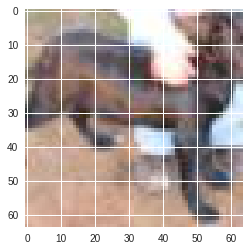

In [0]:
i = np.random.randint(0, len(test_set))
print(i, end = ", ")
img = test_tensor[i,:-1].reshape(3,64,64)
show_img(img, predict_labels[i])

In [0]:
import csv
import glob

def mapping_predict(predicts):
    """when convert dataset(using pytorch.utils.data.ImageFolder) to a tensor,
    the index of the tensor corresponds to the order of the filename, which is:
       predicts[0] -> label for str_indices[0] -> 1.jpg
       predicts[1] -> label for str_indices[1] -> 10.jpg
       predicts[2] -> label for str_indices[2] -> 100.jpg
    what we really need is a new_predicts, where:
       new_predicts[0] -> 1.jpg
       new_predicts[1] -> 2.jpg
       ...
    """
    print(predicts.shape)
    str_indices = [str(i) for i in range(1, 5000)]
    str_indices = sorted(str_indices)
    new_predicts = [None for i in range(4999)]
    for i in range(4999):
        index = str_indices.index(str(i+1))
        new_predicts[i] = predicts[index]
    
    return new_predicts


def predict_to_csv(predicts, file_path):
    #predicts = mapping_predict(predicts)
    int2labels = {0:"Cat", 1:"Dog"}
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter = ',')
        writer.writerow(("id", "label"))
        for i, label in enumerate(predicts):
            writer.writerow((i+1, int2labels[predicts[i]]))
    debug("save predict csv files of model to: {}".format(file_path))

In [0]:
predicts = mapping_predict(predict_labels)
predict_to_csv(predicts, "submissions/model_agm.csv")

(4999,)
save predict csv files of model to: submissions/model_agm.csv


In [0]:
predicts[0:20]

[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1]